# Model Troll Tweets

In [1]:
# import findspark
# findspark.init()

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql import HiveContext
from pyspark.ml.feature import HashingTF, IDF, Tokenizer
from pyspark.ml.feature import StopWordsRemover

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
spark = SparkSession.builder.appName('rus_trolls').getOrCreate()

# Change configuration settings on Spark 
conf = spark.sparkContext._conf.setAll([('spark.executor.memory', '8g'), ('spark.app.name', 'Spark Updated Conf'), ('spark.executor.cores', '4'), ('spark.cores.max', '4'), ('spark.driver.memory','4g')])

# Print spark configuration settings
spark.sparkContext.getConf().getAll()

[('spark.driver.memory', '4g'),
 ('spark.executor.id', 'driver'),
 ('spark.driver.host', 'joshuas-mbp'),
 ('spark.executor.cores', '4'),
 ('spark.cores.max', '4'),
 ('spark.app.name', 'Spark Updated Conf'),
 ('spark.rdd.compress', 'True'),
 ('spark.app.id', 'local-1552458890267'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.master', 'local[*]'),
 ('spark.executor.memory', '8g'),
 ('spark.driver.port', '57716'),
 ('spark.submit.deployMode', 'client'),
 ('spark.ui.showConsoleProgress', 'true')]

In [3]:
sc = spark.sparkContext
# hc = HiveContext(sc)

# Read data

In [5]:
hive_context = HiveContext(sc)
df = hive_context.table("tywang.trolls_non_trolls")
df.show(10)

+--------+--------------------+
|   class|          tweet_text|
+--------+--------------------+
|innocent|@angelayee hey gi...|
|innocent|i HATE the rain i...|
|innocent|@jasontryfon Thin...|
|innocent|o gosh need help ...|
|innocent|Aww man, it sound...|
|innocent|watching the dark...|
|innocent|just learned I ca...|
|innocent|Uuuuuuuuuuuugh an...|
|innocent|@jacobawhite Have...|
|innocent|@tkorte20 peeps I...|
+--------+--------------------+
only showing top 10 rows



In [10]:
df = spark.read.csv('trolls_non_trolls.csv', inferSchema=True, header=False)

In [11]:
df.show(5)

+-----+--------------------+
|  _c0|                 _c1|
+-----+--------------------+
|troll|RT @RappersIQ: #P...|
|troll|RT @BlackNewsOutl...|
|troll|RT @Herobright2: ...|
|troll|Mexico City metro...|
|troll|And will replace ...|
+-----+--------------------+
only showing top 5 rows



In [12]:
oldColumns = df.schema.names
newColumns = ["label", "tweet_text"]

for i in range(0, len(oldColumns)):
    df = df.withColumnRenamed(oldColumns[i], newColumns[i])

In [13]:
df.groupBy("label").count().show()

+--------+-------+
|   label|  count|
+--------+-------+
|   troll|1358472|
|innocent|1600000|
+--------+-------+



In [14]:
df.dropna().groupBy("label").count().show()

+--------+-------+
|   label|  count|
+--------+-------+
|   troll|1358460|
|innocent|1599960|
+--------+-------+



In [15]:
from pyspark.sql.types import *
from pyspark.sql.functions import udf

def modify_values(r):
    if r == "troll":
        return 1
    else:
        return 0
ol_val = udf(modify_values, IntegerType())
df = df.withColumn("label", ol_val(df["label"]))

In [16]:
df.dropna().groupBy("label").count().show()

+-----+-------+
|label|  count|
+-----+-------+
|    1|1358460|
|    0|1599960|
+-----+-------+



In [17]:
df = df.dropna()

# Transform data

In [18]:
from pyspark.sql.types import *

def lower_clean_str(x):
    punc='!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'
    lowercased_str = x.lower()
    for ch in punc:
        lowercased_str = lowercased_str.replace(ch, '')
    return lowercased_str

In [19]:
clean_text = udf(lower_clean_str, StringType())
df = df.withColumn("tweet_text", clean_text(df["tweet_text"]))

In [20]:
df.show(5)

+-----+--------------------+
|label|          tweet_text|
+-----+--------------------+
|    1|rt rappersiq papo...|
|    1|rt blacknewsoutle...|
|    1|rt herobright2 un...|
|    1|mexico city metro...|
|    1|and will replace ...|
+-----+--------------------+
only showing top 5 rows



In [21]:
df_pandas = df.toPandas(); df_pandas.to_csv("trolls_non_trolls2.csv", sep=",")

In [19]:
df.filter(df.label == 1).show(5, False)

+-----+--------------------------------------------------------------------------------------------------------------+
|label|tweet_text                                                                                                    |
+-----+--------------------------------------------------------------------------------------------------------------+
|1    |rt rappersiq papoose ft remyma black love remix pro httpstcolbcdbbi1q9 tbt day follows play meet fav rt       |
|1    |rt blacknewsoutlet bobby seale and huey newton                                                                |
|1    |rt herobright2 unhumanrights nigeria cries out avengers have finished us httpstco3gyrfspkbx httpstcol8rbswp81v|
|1    |mexico city metro now has a penis seat to combat sexual harassment httpstcomvodlyinys                         |
|1    |and will replace it with magister because you know                                                            |
+-----+-----------------------------------------

In [66]:
# Split data into train and test
splits = df.randomSplit([0.8, 0.2])
train_df = splits[0]
test_df = splits[1]

train_df.show(1)

+-----+--------------------+
|label|          tweet_text|
+-----+--------------------+
|    0|	 we love album  ...|
+-----+--------------------+
only showing top 1 row



In [55]:
tokenizer = Tokenizer(inputCol="tweet_text", outputCol="words")
df_words = tokenizer.transform(df)
df_words = df_words.drop("tweet_text")
df_words.show(5)

+-----+--------------------+
|label|               words|
+-----+--------------------+
|    0|[angelayee, hey, ...|
|    0|[i, hate, the, ra...|
|    0|[jasontryfon, thi...|
|    0|[o, gosh, need, h...|
|    0|[aww, man, it, so...|
+-----+--------------------+
only showing top 5 rows



In [22]:
# Remove stop words
remover = StopWordsRemover(inputCol="words", outputCol="filtered_content")
df_words_removed_sw = remover.transform(df_words)

# Drop the redundant source column
df_words_removed_sw = df_words_removed_sw.drop("words")
df_words_removed_sw.show(5)

+-----+--------------------+
|class|    filtered_content|
+-----+--------------------+
|    0|[angelayee, hey, ...|
|    0|[hate, rain, hate...|
|    0|[jasontryfon, thi...|
|    0|[o, gosh, need, h...|
|    0|[aww, man, sounds...|
+-----+--------------------+
only showing top 5 rows



In [23]:
hashingTF = HashingTF(inputCol="filtered_content", outputCol="rawFeatures", numFeatures=20)
featurizedData = hashingTF.transform(df_words_removed_sw)

idf = IDF(inputCol="rawFeatures", outputCol="features")
idfModel = idf.fit(featurizedData)
nlpdf = idfModel.transform(featurizedData)
nlpdf.select("label", "features").show(10)

+-----+--------------------+
|class|            features|
+-----+--------------------+
|    0|(20,[3,4,5,6,7,9,...|
|    0|(20,[9,18],[3.552...|
|    0|(20,[0,3,4,6,9,10...|
|    0|(20,[0,7,10,14,15...|
|    0|(20,[6,7,10,13,19...|
|    0|(20,[3,8,9,11,15,...|
|    0|(20,[1,2,5,6,9,11...|
|    0|(20,[4,7,9,16,19]...|
|    0|(20,[3,15,17],[1....|
|    0|(20,[6,12,13,16,1...|
+-----+--------------------+
only showing top 10 rows



In [24]:
# # Learn a mapping from words to Vectors
# from pyspark.ml.feature import Word2Vec
# word2Vec = Word2Vec(vectorSize=5, minCount=0, inputCol="filtered_content", outputCol="wordVectors")
# w2VM = word2Vec.fit(df_words_removed_sw)
# nlpdf_w2v = w2VM.transform(df_words_removed_sw)

In [25]:
# Split data into train and test
splits = nlpdf.randomSplit([0.8, 0.2])
train_df = splits[0]
test_df = splits[1]

train_df.show(1)

+-----+----------------+-----------+----------+
|class|filtered_content|rawFeatures|  features|
+-----+----------------+-----------+----------+
|    0|              []| (20,[],[])|(20,[],[])|
+-----+----------------+-----------+----------+
only showing top 1 row



In [28]:
# Set parameters for Logistic Regression
from pyspark.ml.classification import LogisticRegression

lgr = LogisticRegression(maxIter=10, featuresCol="features", labelCol="label", regParam=0.01)

# Fit the model to the data.
lgrm = lgr.fit(train_df)

# Given a dataset, predict each point's label, and show the results.
predictions = lgrm.transform(test_df)

In [27]:
# print evaluation metrics
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")

print(evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"}))
print(evaluator.evaluate(predictions, {evaluator.metricName: "f1"}))

0.6730933633295838
0.6675709023001818


In [ ]:
from pyspark.ml.evaluation import 

In [67]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml import Pipeline

lr = LogisticRegression(maxIter=10, featuresCol="features", labelCol="label", regParam=0.01)

paramGrid = ParamGridBuilder() \
    .addGrid(hashingTF.numFeatures, [10, 100, 1000]) \
    .addGrid(lr.regParam, [0.1, 0.01]) \
    .build()

# Configure an ML pipeline, which consists of tree stages: tokenizer, hashingTF, and lr.
pipeline = Pipeline(stages=[tokenizer, remover, hashingTF, idf, lr])

crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=BinaryClassificationEvaluator(),
                          numFolds=3)  # use 3+ folds in practice

# Run cross-validation, and choose the best set of parameters.
cvModel = crossval.fit(train_df)

# Make predictions on test documents. cvModel uses the best model found (lrModel).
predictions = cvModel.transform(test_df)

In [68]:
#print evaluation metrics
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")

print(evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"}))
print(evaluator.evaluate(predictions, {evaluator.metricName: "f1"}))

0.8516960594919092
0.8501931325857981


[Tokenizer_e452ecdc0d9a,
 StopWordsRemover_2c2e855698f6,
 HashingTF_c2f71bd19c7d,
 IDF_30e7cf4267b7,
 LogisticRegressionModel: uid = LogisticRegression_2e1ca998c88e, numClasses = 2, numFeatures = 1000]

In [84]:
cvModel.bestModel.save('best_model')

In [96]:
!ls

Analysis.ipynb	data_cleaning1.ipynb  data_cleaning.ipynb  model.ipynb


In [ ]:
import pickle

with open()

In [33]:
import matplotlib.pyplot as plt
plt.figure(figsize=(5,5))
plt.plot([0, 1], [0, 1], 'r--')
plt.plot(cvModel.summary.roc.select('FPR').collect(),
         cvModel.summary.roc.select('TPR').collect())
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()


+-----+----------------+-----------+----------+
|class|filtered_content|rawFeatures|  features|
+-----+----------------+-----------+----------+
|    0|              []| (20,[],[])|(20,[],[])|
|    0|              []| (20,[],[])|(20,[],[])|
|    0|              []| (20,[],[])|(20,[],[])|
|    0|              []| (20,[],[])|(20,[],[])|
|    0|              []| (20,[],[])|(20,[],[])|
+-----+----------------+-----------+----------+
only showing top 5 rows



_________
Fit the best model again

In [20]:
# Tokenize
tokenizer = Tokenizer(inputCol="tweet_text", outputCol="words")
df_words = tokenizer.transform(df)
df_words = df_words.drop("tweet_text")

# Remove stop words
remover = StopWordsRemover(inputCol="words", outputCol="filtered_content")
df_words_removed_sw = remover.transform(df_words)

# Drop the redundant source column
df_words_removed_sw = df_words_removed_sw.drop("words")

# Hashing
hashingTF = HashingTF(inputCol="filtered_content", outputCol="rawFeatures", numFeatures=1000)
featurizedData = hashingTF.transform(df_words_removed_sw)

idf = IDF(inputCol="rawFeatures", outputCol="features")
idfModel = idf.fit(featurizedData)
nlpdf = idfModel.transform(featurizedData)

# Split data into train and test
splits = nlpdf.randomSplit([0.8, 0.2])
train_df = splits[0]
test_df = splits[1]

# Set parameters for Logistic Regression
from pyspark.ml.classification import LogisticRegression

lgr = LogisticRegression(maxIter=10, featuresCol="features", labelCol="label", regParam=0.01)

# Fit the model to the data.
lgrm = lgr.fit(train_df)

# Given a dataset, predict each point's label, and show the results.
predictions = lgrm.transform(test_df)

In [23]:
nlpdf.show(5)

+-----+--------------------+--------------------+--------------------+
|label|    filtered_content|         rawFeatures|            features|
+-----+--------------------+--------------------+--------------------+
|    1|[rt, rappersiq, p...|(1000,[11,92,118,...|(1000,[11,92,118,...|
|    1|[rt, blacknewsout...|(1000,[2,48,51,43...|(1000,[2,48,51,43...|
|    1|[rt, herobright2,...|(1000,[2,208,240,...|(1000,[2,208,240,...|
|    1|[mexico, city, me...|(1000,[47,114,245...|(1000,[47,114,245...|
|    1|[replace, magiste...|(1000,[779,787,96...|(1000,[779,787,96...|
+-----+--------------------+--------------------+--------------------+
only showing top 5 rows



In [21]:
# print evaluation metrics
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")

print(evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"}))
print(evaluator.evaluate(predictions, {evaluator.metricName: "f1"}))

0.8444912842494963
0.8428474025182624


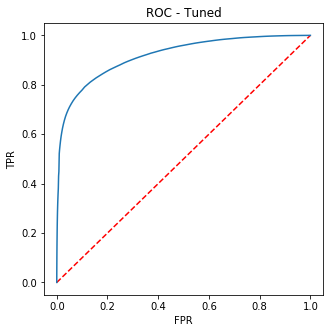

In [22]:
import matplotlib.pyplot as plt
plt.figure(figsize=(5,5))
plt.plot([0, 1], [0, 1], 'r--')
plt.plot(lgrm.summary.roc.select('FPR').collect(),
         lgrm.summary.roc.select('TPR').collect())
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title("ROC - Tuned")
plt.savefig('roc_tuned.png')
plt.show()